# EPG Benchmark

We will compare accuracy and runtime with [Sycomore](https://sycomore.readthedocs.io/en/latest/epg/index.html) and [mri-sim-py](https://github.com/utcsilab/mri-sim-py). We will simulate a Fast Spin Echo acquisition for Myelin Water Fraction mapping (with and without exchange between myelin water and free water).

First, we define some utilities to plot signals:

In [1]:
%matplotlib inline
        
import numpy as np
import matplotlib.pyplot as plt

# plotting
def display_signal(input, legend=None, symbol='-', color=None):
    if color is not None:
        plt.gca().set_prop_cycle(plt.cycler("color", color))
    plt.plot(abs(input), symbol)
    plt.xlim([0, len(input)])
    plt.xlabel("TR index")
    plt.ylabel("signal magnitude [a.u.]")
    if legend is not None:
        plt.legend(legend)
    plt.tight_layout()

## Reference implementation

Reference implementations of using [mri-sim-py](mri-sim-py](https://github.com/utcsilab/mri-sim-py) (Pytorch backend, GPU-accelerated, no exchange, magnetization transfer or flow) and [Sycomore](https://sycomore.readthedocs.io/en/latest/epg/index.html) (C++ backend, CPU-only, not parallelized across multiple atoms, accounts for exchange, magnetization transfer and flow).

In [ ]:
# load ground truth EPG-X data
import scipy

ground_truth = scipy.io.loadmat("notebooks/epgxsignal.mat")
sig0noex = ground_truth["s0"]  
sig0ex = ground_truth["s"]  

In [2]:
# mri-sim-py implementation
import torch
import mrisimpy as simpy

def mrisimpy_fse(flip, phases, ESP, T1, T2, device):
    # sequence parameters
    flip = torch.as_tensor(flip, dtype=torch.float32, device=device)
    phases = torch.as_tensor(phases, dtype=torch.float32, device=device)

    # convert to array  
    T1 = torch.atleast_1d(torch.as_tensor(T1, dtype=torch.float32, device=device)) 
    T2 = torch.atleast_1d(torch.as_tensor(T2, dtype=torch.float32, device=device))
    
    # broadcast
    T1, T2 = torch.broadcast_tensors(T1, T2)

   # do computation
    signal = simpy.



In [9]:
# Sycomore implementation
import multiprocess as mp
import time

import sycomore
from sycomore.units import *

def _sycomore_fse(flip, ESP, T1, T2, T1b=None, T2b=None, k=None, fb=None):
    # parse 
    npulses = flip.shape[0]
    
    # initialize spin system
    if T1b is None:
        species = sycomore.Species(T1, T2)

        # initialize model
        model = sycomore.epg.Regular(species)
    else:
        species_a = sycomore.Species(T1, T2)
        species_b = sycomore.Species(T1b, T2b)
        M0a = np.asarray([0.0, 0.0, 1-fb], dtype=np.float64)
        M0b = np.asarray([0.0, 0.0, fb], dtype=np.float64)
        k_a = k * fb

        # initialize model
        model = sycomore.epg.Regular(species_a, species_b, M0a, M0b, k_a)
    
    # initialize output
    signal = np.zeros(npulses, dtype=np.complex64)

    # excitation
    model.apply_pulse(90.0 * deg)
    
    # loop over flip angles
    for n in range(npulses):
        
        # apply relaxation
        model.relaxation(0.5 * ESP)

        # shift states
        model.shift()
        
        # apply rf
        model.apply_pulse(flip[n])

        # shift states
        model.shift()

        # apply relaxation
        model.relaxation(0.5 * ESP)

        # record signal
        signal[n] = model.echo

    return signal
    
def sycomore_fse(flip, phases, ESP, T1, T2, T1b=None, T2b=None, k=None, fb=None, verbose=False, parallel=False):

    # sequence parameters
    flip = np.asarray(flip) * deg
    ESP = ESP * ms

    # convert to array  
    T1 = np.atleast_1d(np.asarray(T1)) 
    T2 = np.atleast_1d(np.asarray(T2))

    if T1b is not None:
        T1b = np.atleast_1d(np.asarray(T1b)) 
        T2b = np.atleast_1d(np.asarray(T2b))
        k = np.atleast_1d(np.asarray(k))
        fb = np.atleast_1d(np.asarray(fb))
        
    # broadcast
    if T1b is None:
        T1, T2 = np.broadcast_arrays(T1, T2)
    else:
        T1, T2, T1b, T2b, k, fb = np.broadcast_arrays(T1, T2, T1b, T2b, k, fb)

    # units
    T1 = T1 * ms
    T2 = T2 * ms

    if T1b is not None:
        T1b = T1b * ms
        T2b = T2b * ms
        k = k * Hz

    # get natoms
    natoms = T1.shape[0]
    
    # run
    if parallel is False:
        engine = _sycomore_fse
        t0 = time.time()
        if T1b is None:
            signal = [engine(flip, ESP, T1[n], T2[n]) for n in range(natoms)]
        else:
            signal = [engine(flip, ESP, T1[n], T2[n], T1b[n], T2b[n], k[n], fb[n]) for n in range(natoms)]
        t1 = time.time()
        if verbose:
            return np.stack(signal, axis=0).squeeze(), t1-t0
        else:
            return np.stack(signal, axis=0).squeeze()
    else:
        if T1b is None:
            engine = lambda t1, t2 : _sycomore_fse(flip, TR, t1, t2)
        else:
            engine = lambda t1, t2, t1b, t2b, kk, ff : _sycomore_fse(flip, TR, t1, t2, t1b, t2b, kk, ff)
        t0 = time.time()
        if T1b is None:
            with mp.Pool(mp.cpu_count()) as p:
                signal = p.starmap(engine, zip(T1, T2))
        else:
            with mp.Pool(mp.cpu_count()) as p:
                signal = p.starmap(engine, zip(T1, T2, T1b, T2b, k, fb))
        t1 = time.time()
        if verbose:
            return np.stack(signal, axis=0), t1-t0
        else:
            return np.stack(signal, axis=0)
        

## Validation

In [15]:
import epgtorchx as epgx

# parameters
flip = 50 * [180.0]
phases = 50 * [0.0]
ESP = 5.0

T1 = 1000.0 # [500.0, 833.0, 2569.0]
T2 = 100.0  # 

T1b = 500.0 # ms 
T2b = 20.0 # ms 

f = 0.2
k = 10.0 # Hz  

# computation
# sig0, rt0 = sycomore_fse(False, flip, phases, ESP, T1, T2, T1b, T2b, k, f, verbose=True)
sig0, rt1 = epgx.fse(flip, phases, ESP, T1, T2, verbose=True)
sig1, rt1 = epgx.fse(flip, phases, ESP, T1, T2, T1bm=T1b, T2bm=T2b, kbm=k, weight_bm=f, verbose=True)

In [16]:
print(rt0)
print(rt1)

0.00049591064453125
{'trun': 0.13273906707763672}


(None, None)

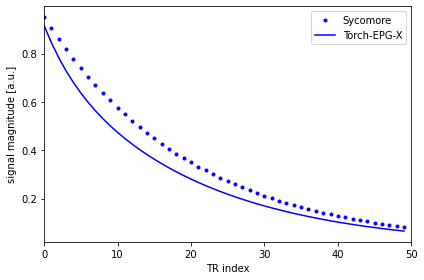

In [17]:
display_signal(sig0.T, color=["b"], symbol='.'), display_signal(sig1.T, color=["b", "r", "g"], symbol='-', legend=["Sycomore", "Torch-EPG-X"])

## Benchmark

In [7]:
# define grid of values
T1 = np.linspace(200.0, 1500.0, 65536)
T2 = 50.0

# run sycomore
sig0, runtime0 = ssfp_sim(flip, TR, T1, T2)

# run deepmr
sig1, runtime1 = bloch.ssfp_sim(flip, TR, T1, T2)
sig2, runtime2 = bloch.ssfp_sim(flip, TR, T1, T2, device="cuda:0")


TypeError: Axes.bar_label() missing 1 required positional argument: 'container'

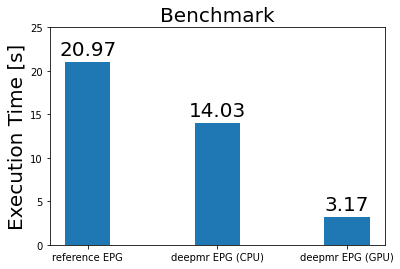

In [12]:
# define labels
labels = ['reference EPG', 'deepmr EPG (CPU)', 'deepmr EPG (GPU)']
runtimes = [round(runtime0, 2), round(runtime1, 2), round(runtime2, 2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, runtimes, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Time [s]', fontsize=20)
ax.set_title('Benchmark', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0.0, 25.0])

ax.bar_label(rects, padding=3, fontsize=20)
ax.bar_label(padding=3, fontsize=20)

fig.tight_layout()